In [1]:
import os, re, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.cm import ScalarMappable

from helpers import load_fixeddepth_summary, collect_summaries, make_key


OUT_DIR = "../paper_figures/"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- ECDF of selections per node (no colorbar here) ----------
def plot_selection_count_ecdf_panel(
    ax, *, summ, cap, lams, network_name,
    cmap, norm,
    axis_fs=12, tick_fs=10
):
    for lam in sorted(lams):
        key = next((
            k for k in summ
            if k.startswith("dynThresh_FRem")
            and re.search(rf"cap{cap:.2f}(?:_|$)", k)
            and re.search(rf"_ds{lam:.2f}(?:_|$)", k)
        ), None)
        if key is None:
            # optional: print warning; skip silently here
            continue

        counts = np.asarray(summ[key]["sel_count_per_node"])
        counts_sorted = np.sort(counts)
        ecdf = np.arange(1, len(counts_sorted) + 1) / len(counts_sorted)

        ax.step(counts_sorted, ecdf, where="post",
                color=cmap(norm(lam)), lw=2, alpha=0.8)

    ax.set_xlabel("Selections per node", fontsize=axis_fs)
    ax.set_ylabel("ECDF", fontsize=axis_fs)
    ax.grid(alpha=0.5, linestyle=":")
    ax.tick_params(labelsize=tick_fs)
    ax.xaxis.set_major_locator(MultipleLocator(8 if network_name == "abm30" else 2))


# ---------- Risk-score distribution overlay at a given step (no colorbar) ----------
def plot_risk_dist_overlay_panel(
    ax, *, summ, cap, lams, step, network_name,
    cmap, norm,
    axis_fs=12, tick_fs=10
):
    for z, lam in enumerate(sorted(lams)):
        key = next((
            k for k in summ
            if k.startswith("dynThresh_FRem")
            and re.search(rf"cap{cap:.2f}(?:_|$)", k)
            and re.search(rf"_ds{lam:.2f}(?:_|$)", k)
        ), None)
        if key is None:
            continue

        cur  = summ[key]
        bins = np.asarray(cur["risk_bins"])
        mids = (bins[:-1] + bins[1:]) / 2
        hist = np.asarray(cur["risk_hist_mean"][step])

        c = cmap(norm(lam))
        ax.fill_between(mids, hist, color=c, alpha=0.10, zorder=z)
        ax.plot(mids, hist, color=c, linewidth=1.2, alpha=0.8, zorder=z+1)

    ax.set_xlim(0, 0.75)             # your preferred common X range
    ax.set_xlabel(r"Risk score $\tilde r$", fontsize=axis_fs)
    ax.set_ylabel("# Nodes", fontsize=axis_fs)
    ax.tick_params(labelsize=tick_fs)
    ax.grid(alpha=0.3, linestyle=":")
    ax.yaxis.set_major_locator(MultipleLocator(100))


# ---------- Alert burden over time (no colorbar) ----------
def plot_alert_burden_over_time_panel(
    ax, *, summ, cap, lams, network_name,
    cmap, norm,
    axis_fs=12, tick_fs=10
):
    last_steps = None
    for lam in sorted(lams):
        key = next((
            k for k in summ
            if k.startswith("dynThresh_FRem")
            and re.search(rf"cap{cap:.2f}(?:_|$)", k)
            and re.search(rf"_ds{lam:.2f}(?:_|$)", k)
        ), None)
        if key is None:
            continue

        cur = summ[key]
        counts = np.asarray(cur["avg_high_risk_node_counts"])
        steps = np.arange(len(counts))
        last_steps = steps  # remember for ticks

        c = cmap(norm(lam))
        ax.plot(steps, counts, color=c, linewidth=1.8, alpha=0.8)
        ax.fill_between(steps, counts, color=c, alpha=0.10)

    ax.set_xlabel("Intervention step", fontsize=axis_fs)
    ax.set_ylabel("# Nodes", fontsize=axis_fs)
    if last_steps is not None:
        ax.set_xticks(last_steps)
    ax.grid(alpha=0.3, linestyle=":")
    ax.tick_params(labelsize=tick_fs)
    ax.xaxis.set_major_locator(MultipleLocator(8 if network_name == "abm30" else 2))


In [2]:
def fig_fig4_abm_dtu(
    *, summ_abm, summ_dtu, out_path="Fig5_ABM_DTU.tif",
    axis_fs=12, tick_fs=10, cmap_name="plasma"
):
    # λ sets & cap/step rules
    lams_abm_dtu = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0]
    cap_abm, step_abm = 0.25, 2
    cap_dtu, step_dtu = 0.50, 4

    # shared λ mapping across both rows
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=min(lams_abm_dtu), vmax=max(lams_abm_dtu))

    fig, axes = plt.subplots(2, 3, figsize=(10.5, 5.2), dpi=150, constrained_layout=True)

    # Row 1 (A,B,C): ABM
    plot_selection_count_ecdf_panel(
        axes[0,1], summ=summ_abm, cap=cap_abm, lams=lams_abm_dtu,
        network_name="abm", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )
    plot_risk_dist_overlay_panel(
        axes[0,0], summ=summ_abm, cap=cap_abm, lams=lams_abm_dtu, step=step_abm,
        network_name="abm", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )
    plot_alert_burden_over_time_panel(
        axes[0,2], summ=summ_abm, cap=cap_abm, lams=lams_abm_dtu,
        network_name="abm", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )

    # Row 2 (D,E,F): DTU
    plot_selection_count_ecdf_panel(
        axes[1,1], summ=summ_dtu, cap=cap_dtu, lams=lams_abm_dtu,
        network_name="DTU", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )
    plot_risk_dist_overlay_panel(
        axes[1,0], summ=summ_dtu, cap=cap_dtu, lams=lams_abm_dtu, step=step_dtu,
        network_name="DTU", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )
    plot_alert_burden_over_time_panel(
        axes[1,2], summ=summ_dtu, cap=cap_dtu, lams=lams_abm_dtu,
        network_name="DTU", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )

    # De-duplicate y-axis titles (keep only on first column)
    for row in (0,1):
        for col in (1,2):
            axes[row, col].set_ylabel("")

    # Panel letters
    letters = "ABCDEF"
    for i in range(2):
        for j in range(3):
            axes[i, j].text(-0.06, 1.06, letters[i*3+j],
                            transform=axes[i, j].transAxes,
                            fontsize=12, fontweight="bold", ha="left", va="bottom")

    # One λ colorbar per row
    for i in (0, 1):
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = fig.colorbar(
            sm, ax=axes[i, :].ravel().tolist(),
            location="right", fraction=0.035, pad=0.02, aspect=25
        )
        cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
        cbar.ax.tick_params(labelsize=tick_fs)

    # Save (PLOS-friendly)
    fig.savefig(out_path, dpi=600, format="tiff",
                pil_kwargs={"compression": "tiff_lzw"},
                bbox_inches="tight")
    print(f"✓ saved {out_path}")
    plt.show()


In [3]:
def fig_fig4_workplace(
    *, summ_workplace, out_path="Fig16_workplace.tif",
    axis_fs=12, tick_fs=10, cmap_name="plasma"
):
    # λ, cap, step for workplace
    lams = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0]
    cap, step = 0.50, 4

    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=min(lams), vmax=max(lams))

    fig, axes = plt.subplots(1, 3, figsize=(10.5, 2.6), dpi=150, constrained_layout=True)

    plot_selection_count_ecdf_panel(
        axes[1], summ=summ_workplace, cap=cap, lams=lams,
        network_name="workplace", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )
    plot_risk_dist_overlay_panel(
        axes[0], summ=summ_workplace, cap=cap, lams=lams, step=step,
        network_name="workplace", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )
    plot_alert_burden_over_time_panel(
        axes[2], summ=summ_workplace, cap=cap, lams=lams,
        network_name="workplace", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )

    # remove duplicate y-labels on right panels
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")

    # letters
    for j, L in enumerate("ABC"):
        axes[j].text(-0.06, 1.06, L, transform=axes[j].transAxes,
                     fontsize=12, fontweight="bold", ha="left", va="bottom")

    # one row colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(),
                        location="right", fraction=0.035, pad=0.02, aspect=25)
    cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
    cbar.ax.tick_params(labelsize=tick_fs)

    fig.savefig(out_path, dpi=600, format="tiff",
                pil_kwargs={"compression": "tiff_lzw"},
                bbox_inches="tight")
    print(f"✓ saved {out_path}")
    plt.show()


In [4]:
def fig_fig4_abm30(
    *, summ_abm30, out_path="Fig10.tif",
    axis_fs=12, tick_fs=10, cmap_name="plasma"
):
    # λ, cap, step for abm30
    lams = [0.5, 1.0, 1.5, 2.0]
    cap, step = 0.25, 4

    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=min(lams), vmax=max(lams))

    fig, axes = plt.subplots(1, 3, figsize=(10.5, 2.6), dpi=150, constrained_layout=True)

    plot_selection_count_ecdf_panel(
        axes[1], summ=summ_abm30, cap=cap, lams=lams,
        network_name="abm30", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )
    plot_risk_dist_overlay_panel(
        axes[0], summ=summ_abm30, cap=cap, lams=lams, step=step,
        network_name="abm30", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )
    plot_alert_burden_over_time_panel(
        axes[2], summ=summ_abm30, cap=cap, lams=lams,
        network_name="abm30", cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
    )

    # remove duplicate y-labels on right panels
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")

    # letters
    for j, L in enumerate("ABC"):
        axes[j].text(-0.06, 1.06, L, transform=axes[j].transAxes,
                     fontsize=12, fontweight="bold", ha="left", va="bottom")

    # one row colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(),
                        location="right", fraction=0.035, pad=0.02, aspect=25)
    cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
    cbar.ax.tick_params(labelsize=tick_fs)

    fig.savefig(out_path, dpi=600, format="tiff",
                pil_kwargs={"compression": "tiff_lzw"},
                bbox_inches="tight")
    print(f"✓ saved {out_path}")
    plt.show()


In [5]:
# --- imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable



# dataset-specific beta/gamma
BG = {
    "DTU":       {"beta": [0.04],  "gamma": [0.005]},
    "abm":       {"beta": [0.01],  "gamma": [0.005]},
    "workplace": {"beta": [0.30],  "gamma": [0.005]},
    "abm30":     {"beta": [0.005], "gamma": [0.002]},
    "abm60":     {"beta": [0.002], "gamma": [0.001]},
}


# build the exact filter dict you gave (but with ibl=True to get the dashed baseline)
def make_filters(network_name):
    return dict(
        variants        = ["without", "dynThresh_FRem"],
        ds              = [0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5, 2],
        fixed_frac      = [0.1, 0.25, 0.5, 1.0, None],
        top_node_frac   = [1.0, None],
        max_rf          = [1.0, None],
        ii              = [24],
        fixed_threshold = [True, False],
        nprv            = [1],
        risk_model      = ["degree"],
        window          = [24],
        accel_weight    = [1.0],
        pt_weight       = [1.0],
        rise_smoothing  = [1],
        drop_smoothing  = [1],
        beta            = BG[network_name]["beta"],
        gamma           = BG[network_name]["gamma"],
        ibl             = [False],   # ← include intervention-baseline for dashed grey
        compliance      = [1.0],
    )

# --- load datasets ------------------------------------------------------------
def load_dataset(network_name):
    RESULTS_DIR = f"../results_{network_name}"
    CACHE_DIR   = f"../cache_{network_name}"
    os.makedirs(CACHE_DIR, exist_ok=True)
    filters = make_filters(network_name)
    print(f"Loading {network_name} …")
    df, cache = load_fixeddepth_summary(RESULTS_DIR, CACHE_DIR, filters)
    return df, cache


df_abm,   cache_abm   = load_dataset("abm")

df_dtu,   cache_dtu   = load_dataset("DTU")
df_office,cache_office= load_dataset("workplace")

summ_abm = collect_summaries(df_abm,   cache_abm)

summ_dtu = collect_summaries(df_dtu,   cache_dtu)
summ_office = collect_summaries(df_office,cache_office)

Loading abm …
Loading 8 baseline + 0 risk-depth + 32 fixed-depth files


✓ results_without_ii24_ds100_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (1/40)
✓ results_without_ii24_ds150_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (2/40)
✓ results_without_ii24_ds50_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (3/40)
✓ results_without_ii24_ds110_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (4/40)
✓ results_without_ii24_ds70_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (5/40)
✓ results_without_ii24_ds200_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (6/40)
✓ results_without_ii24_ds130_mrfNA_fremNA_tnfNA_ibl0_c

✓ saved ../paper_figures/Fig4_ABM_DTU.tif


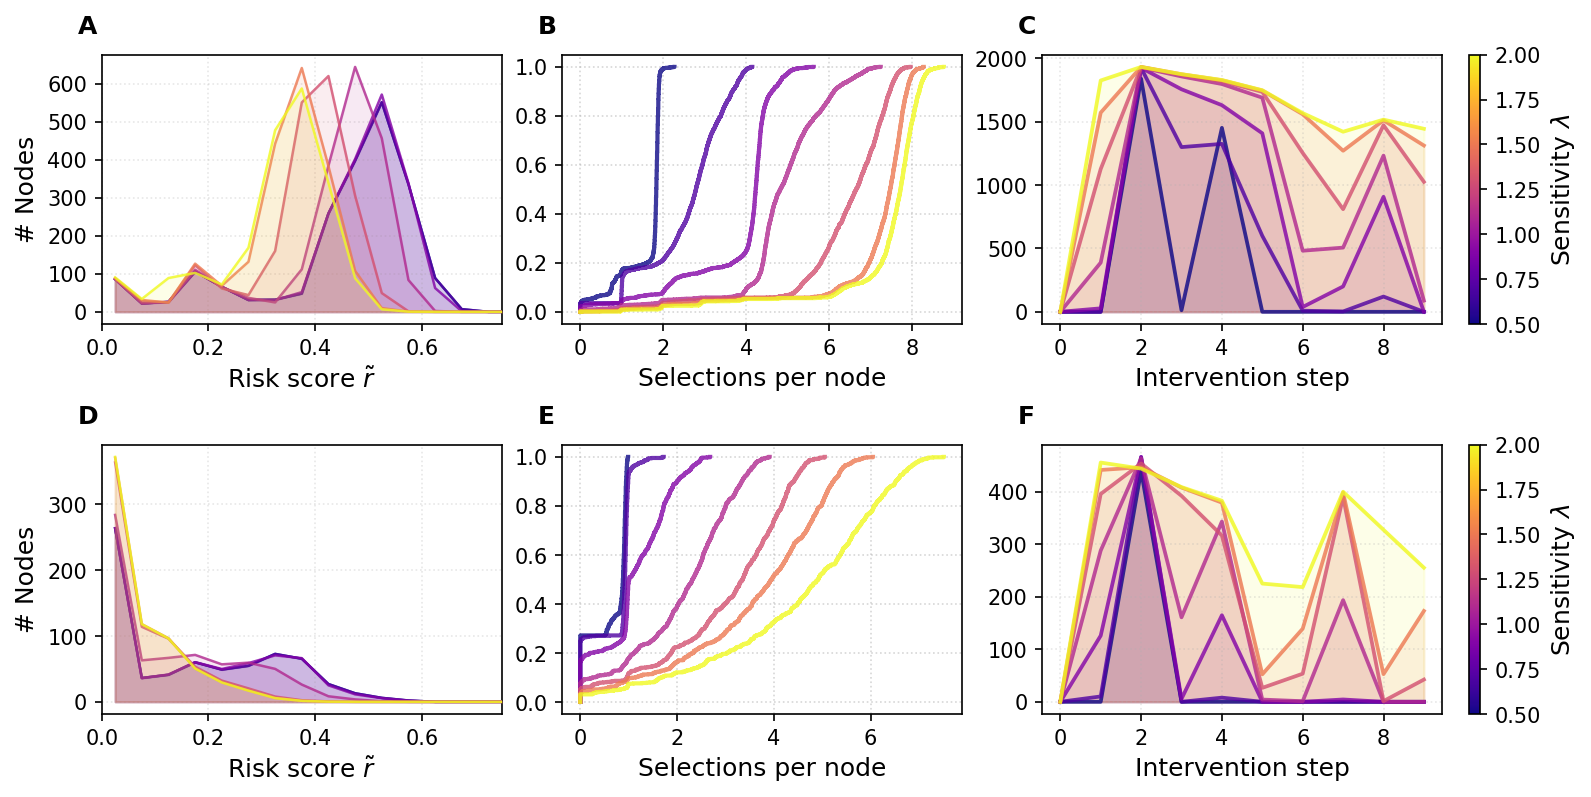

✓ saved ../paper_figures/Fig4_workplace.tif


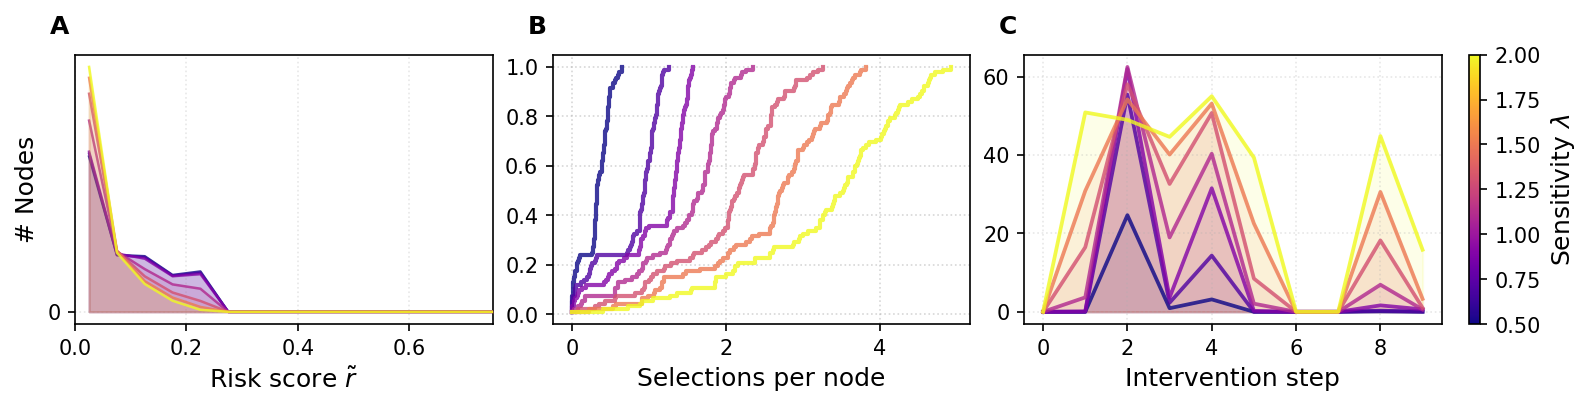

Loading abm30 …
Loading 8 baseline + 0 risk-depth + 28 fixed-depth files
✓ results_without_ii24_ds150_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (1/36)
✓ results_without_ii24_ds50_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (2/36)
✓ results_without_ii24_ds100_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (3/36)
✓ results_without_ii24_ds200_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002_BASELINE.zip (from cache)   (4/36)
✓ results_dynThresh_FRem_ii24_ds100_mrfNA_frem25_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip (from cache)   (5/36)
✓ results_dynThresh_FRem_ii24_ds110_mrfNA_frem25_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p005_g0p002.zip 

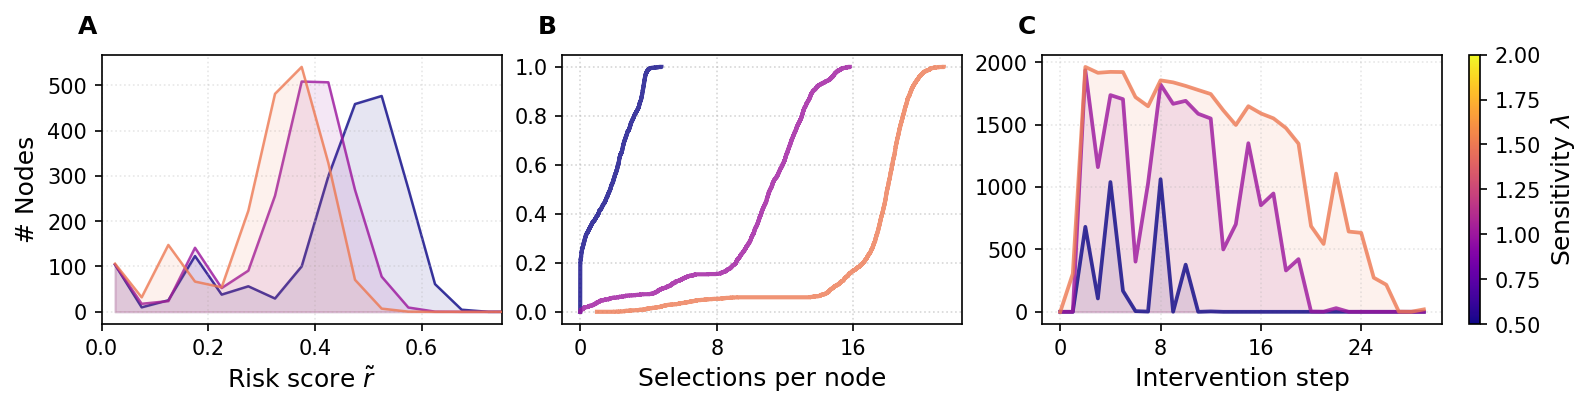

In [6]:


# 2×3: ABM (top) + DTU (bottom)
fig_fig4_abm_dtu(
    summ_abm=summ_abm,
    summ_dtu=summ_dtu,
    out_path=os.path.join(OUT_DIR, "Fig4_ABM_DTU.tif"),
    axis_fs=12, tick_fs=10
)

# 1×3: Workplace
fig_fig4_workplace(
    summ_workplace=summ_office,
    out_path=os.path.join(OUT_DIR, "Fig4_workplace.tif"),
    axis_fs=12, tick_fs=10
)

df_abm30,   cache_abm30   = load_dataset("abm30")
summ_abm30 = collect_summaries(df_abm30,   cache_abm30)

# 1×3: ABM30
fig_fig4_abm30(
    summ_abm30=summ_abm30,
    out_path=os.path.join(OUT_DIR, "Fig4_abm30.tif"),
    axis_fs=12, tick_fs=10
)


In [7]:
# --- imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable



# dataset-specific beta/gamma
BG = {
    "DTU":       {"beta": [0.04],  "gamma": [0.005]},
    "abm":       {"beta": [0.01],  "gamma": [0.005]},
    "workplace": {"beta": [0.30],  "gamma": [0.005]},
    "abm30":     {"beta": [0.005], "gamma": [0.002]},
    "abm60":     {"beta": [0.002], "gamma": [0.001]},
}


# build the exact filter dict you gave (but with ibl=True to get the dashed baseline)
def make_filters(network_name):
    return dict(
        variants        = ["without", "dynThresh_FRem"],
        ds              = [0.5, 0.7, 0.9, 1.1, 1.5, 2],
        fixed_frac      = [0.1, 0.25, 0.5, 1.0, None],
        top_node_frac   = [1.0, None],
        max_rf          = [1.0, None],
        ii              = [24],
        fixed_threshold = [True, False],
        nprv            = [1],
        risk_model      = ["degree"],
        window          = [24],
        accel_weight    = [1.0],
        pt_weight       = [1.0],
        rise_smoothing  = [1],
        drop_smoothing  = [1],
        beta            = BG[network_name]["beta"],
        gamma           = BG[network_name]["gamma"],
        ibl             = [False],   # ← include intervention-baseline for dashed grey
        compliance      = [1.0],
    )

# --- load datasets ------------------------------------------------------------
def load_dataset(network_name):
    RESULTS_DIR = f"../results_{network_name}"
    CACHE_DIR   = f"../cache_{network_name}"
    os.makedirs(CACHE_DIR, exist_ok=True)
    filters = make_filters(network_name)
    print(f"Loading {network_name} …")
    df, cache = load_fixeddepth_summary(RESULTS_DIR, CACHE_DIR, filters)
    return df, cache


df_abm,   cache_abm   = load_dataset("abm")
df_dtu,   cache_dtu   = load_dataset("DTU")
df_office,cache_office= load_dataset("workplace")

summ_abm = collect_summaries(df_abm,   cache_abm)
summ_dtu = collect_summaries(df_dtu,   cache_dtu)
summ_office = collect_summaries(df_office,cache_office)

Loading abm …
Loading 6 baseline + 0 risk-depth + 24 fixed-depth files
✓ results_without_ii24_ds90_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (1/30)
✓ results_dynThresh_FRem_ii24_ds50_mrfNA_frem50_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (2/30)
✓ results_dynThresh_FRem_ii24_ds150_mrfNA_frem10_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (3/30)
✓ results_without_ii24_ds110_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (4/30)
✓ results_dynThresh_FRem_ii24_ds50_mrfNA_frem10_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005.zip (from cache)   (5/30)
✓ results_without_ii24_ds200_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)

In [8]:
import re, os, numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# ─────────────────────────────────────────────────────────────────────────────
# PANEL: concentration curve (one dataset, one φ) — NO COLORBAR HERE
# x: cumulative risk share; y: cumulative burden share; color: λ
# ─────────────────────────────────────────────────────────────────────────────
def plot_concentration_panel(
    ax, *,
    summaries: dict,
    phi: float,
    lambdas: list[float],
    cmap,
    norm,
    axis_fs=12,
    tick_fs=10
):
    cap_re = re.compile(r"_cap([0-9\.]+)")
    ds_re  = re.compile(r"_ds([0-9\.]+)")

    # equality line
    ax.plot([0, 1], [0, 1], color="grey", linestyle="--", linewidth=1)

    rows = []
    for lbl, summ in summaries.items():
        mphi = cap_re.search(lbl); mlam = ds_re.search(lbl)
        if not (mphi and mlam):
            continue
        cur_phi = float(mphi.group(1))
        lam     = float(mlam.group(1))
        if abs(cur_phi - phi) > 1e-9:
            continue
        if lambdas and (lam not in lambdas):
            continue

        burden = np.asarray(summ["edges_removed_per_node"], float)
        risk   = np.asarray(summ["risk_timeavg"], float)
        if burden.size == 0 or burden.size != risk.size:
            continue
        rows.append((lam, burden, risk))

    if not rows:
        return

    for lam, burden, risk in sorted(rows, key=lambda x: x[0]):
        idx = np.argsort(risk)
        r_sorted = risk[idx]
        b_sorted = burden[idx]

        r_sum = float(np.sum(r_sorted))
        b_sum = float(np.sum(b_sorted))

        cum_r = (np.cumsum(r_sorted) / r_sum) if r_sum > 0 else np.linspace(0, 1, len(r_sorted))
        cum_b = (np.cumsum(b_sorted) / b_sum) if b_sum > 0 else np.zeros_like(b_sorted)

        pop   = np.arange(1, len(r_sorted)+1) / len(r_sorted)

        # choose x-axis mode
        x_mode = "population"   # set to "population" to reproduce the old plots
        x_vals = cum_r if x_mode == "risk" else pop

        ax.plot(x_vals, cum_b, color=cmap(norm(lam)), linewidth=1.8, alpha=0.6)

    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_xlabel("Cumulative risk share" if x_mode=="risk" else "Cumulative population share", fontsize=axis_fs)
    ax.set_ylabel("Cumulative\nburden share", fontsize=axis_fs)
    ax.tick_params(labelsize=tick_fs)
    ax.grid(linestyle=":", alpha=0.3)


# ─────────────────────────────────────────────────────────────────────────────
# FIGURE 1: one row (A–C) — ABM, DTU, Workplace at φ = 0.25
# ─────────────────────────────────────────────────────────────────────────────
def fig_concentration_row_phi025(
    *,
    summ_abm: dict,
    summ_dtu: dict,
    summ_workplace: dict,
    lambdas = (0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0),
    out_path = "Fig7.tif",
    cmap_name = "plasma",
    figsize = (10.0, 2.7),  # ~3.2 in per panel
    axis_fs = 12,
    tick_fs = 10
):
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=min(lambdas), vmax=max(lambdas))

    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=150, constrained_layout=True)
    datasets = [summ_abm, summ_dtu, summ_workplace]

    for j, summ in enumerate(datasets):
        plot_concentration_panel(
            axes[j], summaries=summ, phi=0.25, lambdas=list(lambdas),
            cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
        )
        if j > 0:  # y-label only on first column
            axes[j].set_ylabel("")

    # panel letters
    for j, L in enumerate("ABC"):
        axes[j].text(-0.06, 1.06, L, transform=axes[j].transAxes,
                     fontsize=12, fontweight="bold", ha="left", va="bottom")

    # one λ colorbar for the row
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(),
                        location="right", fraction=0.035, pad=0.02, aspect=25)
    cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
    cbar.ax.tick_params(labelsize=tick_fs)

    fig.savefig(out_path, dpi=600, format="tiff",
                pil_kwargs={"compression": "tiff_lzw"},
                bbox_inches="tight")
    print(f"✓ saved {out_path}")
    plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# FIGURE 2: three rows (A–I)
# rows = φ ∈ {0.10, 0.50, 1.00}; columns = ABM, DTU, Workplace
# one λ colorbar per row; y-label only on first column
# ─────────────────────────────────────────────────────────────────────────────
def fig_concentration_grid_3phis(
    *,
    summ_abm: dict,
    summ_dtu: dict,
    summ_workplace: dict,
    phis = (0.10, 0.50, 1.00),
    lambdas = (0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0),
    out_path = "Fig15.tif",
    cmap_name = "plasma",
    figsize = (10.0, 8.4),  # ~2.6–2.8 in per row
    axis_fs = 12,
    tick_fs = 10
):
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=min(lambdas), vmax=max(lambdas))

    fig, axes = plt.subplots(len(phis), 3, figsize=figsize, dpi=150, constrained_layout=True)
    summaries = [summ_abm, summ_dtu, summ_workplace]

    # draw panels
    for i, phi in enumerate(phis):
        for j, summ in enumerate(summaries):
            ax = axes[i, j] if len(phis) > 1 else axes[j]
            plot_concentration_panel(
                ax, summaries=summ, phi=phi, lambdas=list(lambdas),
                cmap=cmap, norm=norm, axis_fs=axis_fs, tick_fs=tick_fs
            )
            if j > 0:
                ax.set_ylabel("")

        # λ colorbar for this row
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = fig.colorbar(sm, ax=axes[i, :].ravel().tolist(),
                            location="right", fraction=0.035, pad=0.02, aspect=25)
        cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
        cbar.ax.tick_params(labelsize=tick_fs)

    # panel letters (A–I)
    letters = "ABCDEFGHI"
    k = 0
    for i in range(len(phis)):
        for j in range(3):
            axes[i, j].text(-0.06, 1.06, letters[k], transform=axes[i, j].transAxes,
                            fontsize=12, fontweight="bold", ha="left", va="bottom")
            k += 1

    fig.savefig(out_path, dpi=600, format="tiff",
                pil_kwargs={"compression": "tiff_lzw"},
                bbox_inches="tight")
    print(f"✓ saved {out_path}")
    plt.show()


✓ saved ../paper_figures/Fig_concentration_phi025_row.tif


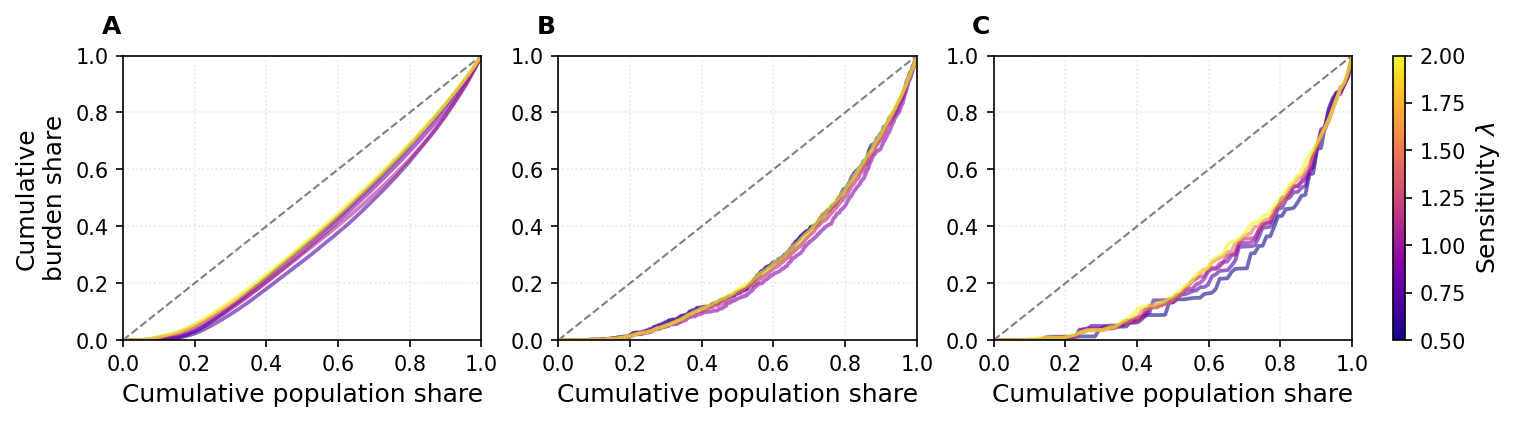

✓ saved ../paper_figures/Fig_concentration_3rows_allDatasets.tif


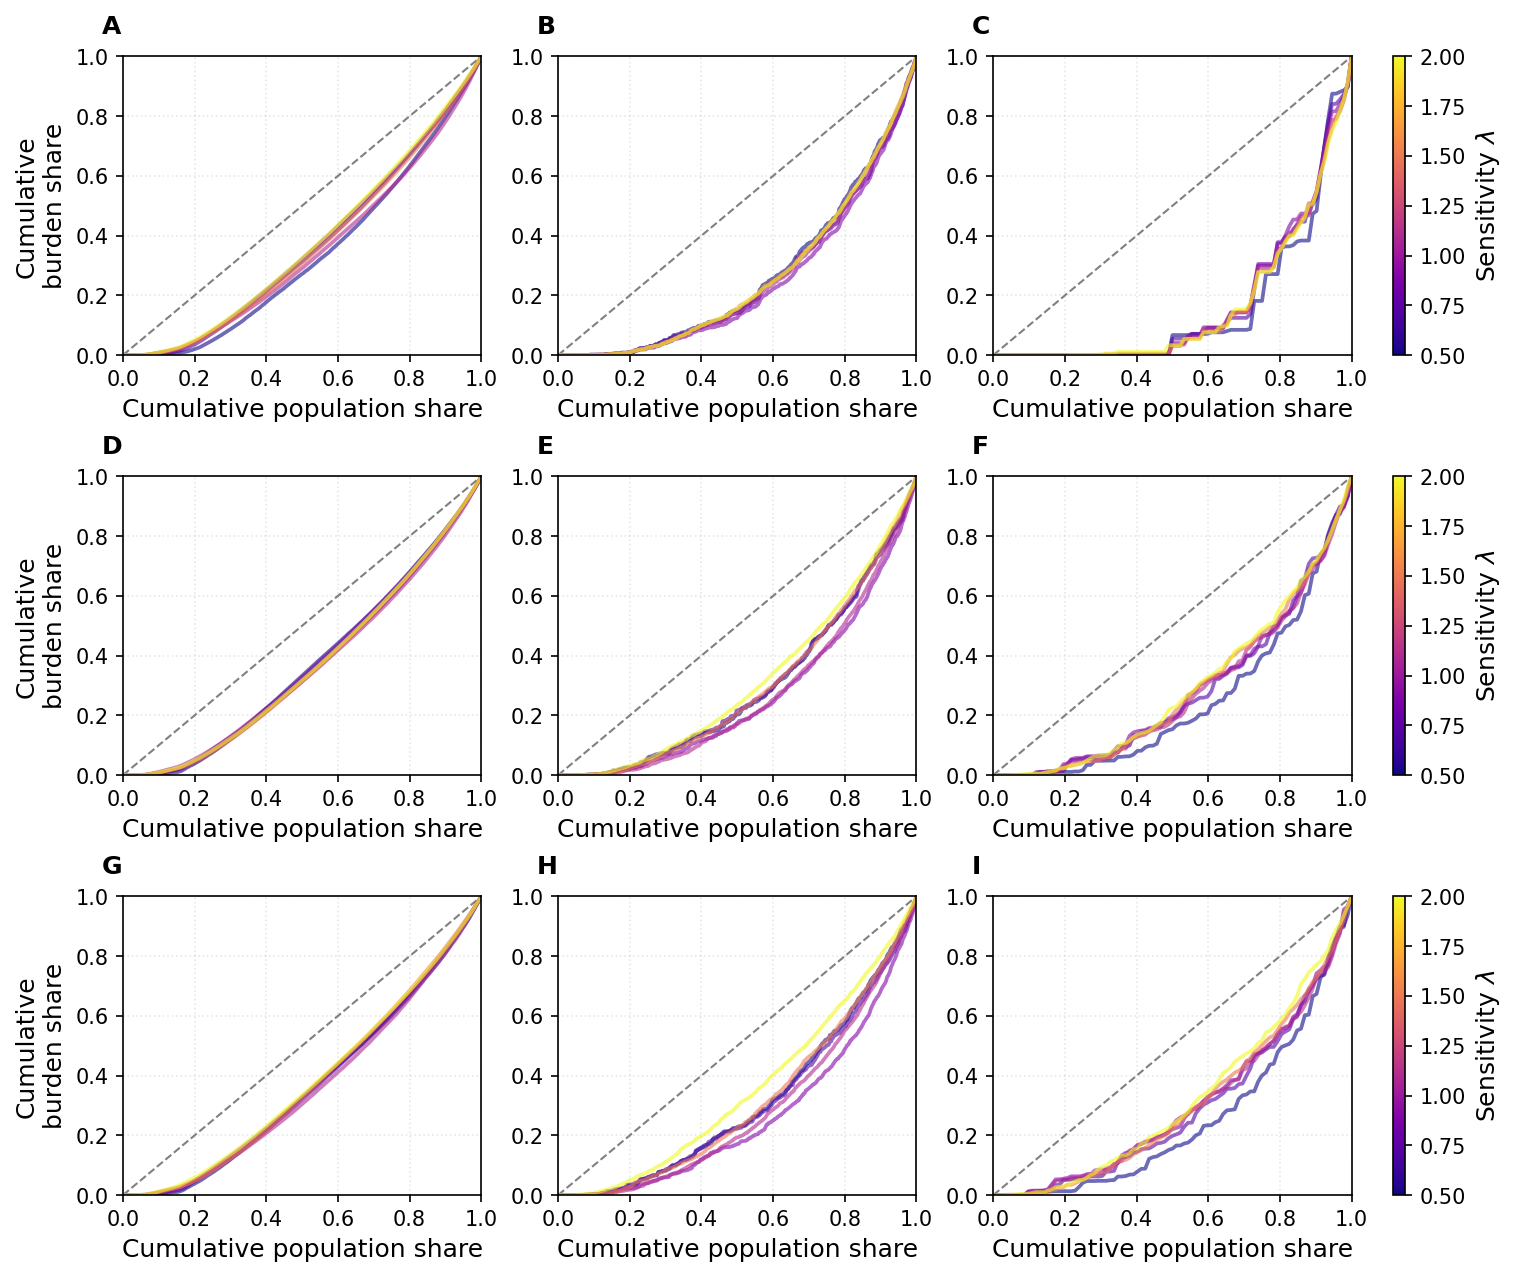

In [9]:
LAM_ALL = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0]

# 1) One-row (ϕ = 0.25): ABM | DTU | Workplace
fig_concentration_row_phi025(
    summ_abm=summ_abm,
    summ_dtu=summ_dtu,
    summ_workplace=summ_office,
    lambdas=LAM_ALL,
    out_path=os.path.join(OUT_DIR, "Fig_concentration_phi025_row.tif")
)

# 2) Three-row (ϕ ∈ {0.10, 0.50, 1.00}) × (ABM, DTU, Workplace)
fig_concentration_grid_3phis(
    summ_abm=summ_abm,
    summ_dtu=summ_dtu,
    summ_workplace=summ_office,
    phis=[0.10, 0.50, 1.00],
    lambdas=LAM_ALL,
    out_path=os.path.join(OUT_DIR, "Fig_concentration_3rows_allDatasets.tif")
)
